## Feature Engineering Objective
本ノートでは、需要予測モデルに入力するために、
取引データを日 × 店舗 × 商品カテゴリ単位に集約し、
価格・割引・ロイヤルティ施策を表す特徴量を作成する。


In [57]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)

# データの読み込み
df = pd.read_csv("../data/raw/grocery_chain_data.csv")

# 取引日のデータ型の変更
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["date"] = df["transaction_date"].dt.date

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       1980 non-null   int64         
 1   store_name        1955 non-null   object        
 2   transaction_date  1980 non-null   datetime64[ns]
 3   aisle             1980 non-null   object        
 4   product_name      1980 non-null   object        
 5   quantity          1980 non-null   float64       
 6   unit_price        1980 non-null   float64       
 7   total_amount      1980 non-null   float64       
 8   discount_amount   1980 non-null   float64       
 9   final_amount      1980 non-null   float64       
 10  loyalty_points    1980 non-null   int64         
 11  date              1980 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 185.8+ KB


## 販売数量ベースの特徴量の確認

In [58]:
# 日 × 店舗 × 商品のカラムの作成
GROUP_COLS = ["date", "store_name", "aisle"]

# 予測したい物
TARGET_COL = "quantity"

store_name に約1%の欠損が確認されたが、
本分析では日 × 店舗 × 商品カテゴリ単位での集約を行うため、
集約時に除外される欠損行は全体傾向に与える影響が小さいと判断し、
追加の補完処理は行わなかった。

In [59]:
# 集約処理
agg_df = (
    df
    .groupby(GROUP_COLS)
    .agg(
        total_quantity=("quantity", "sum"),
        avg_unit_price=("unit_price", "mean"),
        total_discount=("discount_amount", "sum"),
        total_loyalty_points=("loyalty_points", "sum"),
        transaction_count=("customer_id", "count")
    )
    .reset_index()
)


In [60]:
agg_df.info()
agg_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  1935 non-null   object 
 1   store_name            1935 non-null   object 
 2   aisle                 1935 non-null   object 
 3   total_quantity        1935 non-null   float64
 4   avg_unit_price        1935 non-null   float64
 5   total_discount        1935 non-null   float64
 6   total_loyalty_points  1935 non-null   int64  
 7   transaction_count     1935 non-null   int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 121.1+ KB


,total_quantity,avg_unit_price,total_discount,total_loyalty_points,transaction_count
count,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,2.995866,15.517904,4.511633,257.771576,1.010336
std,1.459195,8.360847,4.984420,150.627864,0.101165
min,1.000000,0.990000,0.000000,0.000000,1.000000
25%,2.000000,8.350000,1.270000,128.000000,1.000000
50%,3.000000,15.200000,3.080000,269.000000,1.000000
75%,4.000000,22.835000,5.485000,379.000000,1.000000
max,10.000000,29.980000,29.940000,895.000000,2.000000


(array([400.,   0.,   0.,   0.,   0., 384.,   0.,   0.,   0.,   0.,   0.,
        391.,   0.,   0.,   0.,   0., 375.,   0.,   0.,   0.,   0.,   0.,
        371.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  1.18,  1.36,  1.54,  1.72,  1.9 ,  2.08,  2.26,  2.44,
         2.62,  2.8 ,  2.98,  3.16,  3.34,  3.52,  3.7 ,  3.88,  4.06,
         4.24,  4.42,  4.6 ,  4.78,  4.96,  5.14,  5.32,  5.5 ,  5.68,
         5.86,  6.04,  6.22,  6.4 ,  6.58,  6.76,  6.94,  7.12,  7.3 ,
         7.48,  7.66,  7.84,  8.02,  8.2 ,  8.38,  8.56,  8.74,  8.92,
         9.1 ,  9.28,  9.46,  9.64,  9.82, 10.  ]),
 <BarContainer object of 50 artists>)

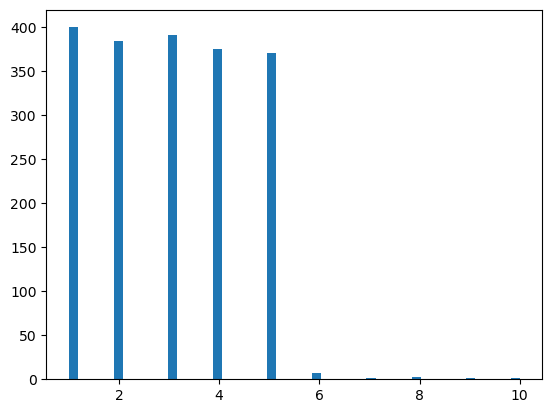

In [61]:
import matplotlib.pyplot as plt

plt.hist(agg_df["total_quantity"], bins=50)


- 売上数量をベースにするとデータが1~5の間に大部分が分布しているため情報量が低いと判断できる。よって特徴量とするのは適切ではないと考えられる。

## 金額ベースの特徴量の確認

In [62]:
# =========================
# 集約：日 × 店舗 × 商品カテゴリ
# =========================
agg_df = (
    df
    .groupby(["transaction_date", "store_name", "aisle"], as_index=False)
    .agg(
        total_quantity=("quantity", "sum"),
        total_amount=("total_amount", "sum"),
        total_discount=("discount_amount", "sum"),
        final_amount=("final_amount", "sum"),
        avg_unit_price=("unit_price", "mean"),
        avg_loyalty_points=("loyalty_points", "mean"),
        transaction_count=("quantity", "count"),
    )
)


In [63]:
# 基礎統計量
display(
    agg_df[["total_amount", "final_amount", "total_discount"]]
    .describe()
    .T
)

,count,mean,std,min,25%,50%,75%,max
total_amount,1935.0,46.310667,35.225027,1.01,18.450,37.80,68.345,218.24
final_amount,1935.0,41.799034,32.779602,-3.43,16.235,33.54,61.055,208.36
total_discount,1935.0,4.511633,4.984420,0.00,1.270,3.08,5.485,29.94


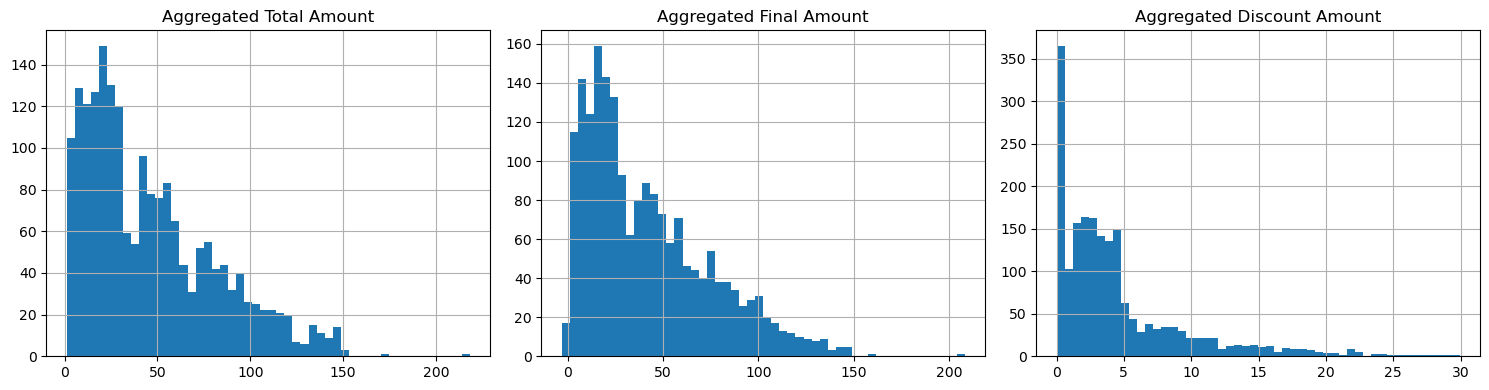

In [64]:
# 分布確認
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

agg_df["total_amount"].hist(bins=50, ax=axes[0])
axes[0].set_title("Aggregated Total Amount")

agg_df["final_amount"].hist(bins=50, ax=axes[1])
axes[1].set_title("Aggregated Final Amount")

agg_df["total_discount"].hist(bins=50, ax=axes[2])
axes[2].set_title("Aggregated Discount Amount")

plt.tight_layout()
plt.show()

In [65]:
# 異常値・ゼロ確認
display(
    (agg_df[["total_amount", "final_amount", "total_discount"]] <= 0).sum()
)

total_amount        0
final_amount       11
total_discount    326
dtype: int64

- 最終的な金額がマイナスになるのは高い割引率が原因だと考えられる。しかし最終的な金額がマイナスになることは現実的にはあり得ないためマイナスの値を0にする処理を行う。

In [66]:
# final_amount の負の値を 0 にクリップ
agg_df["final_amount"] = agg_df["final_amount"].clip(lower=0)

## 特徴量の作成
これまでの結果から売上数量を使った特徴量では情報量が低いことが分かったため、金額ベースで特徴量を作る。目的変数はfinal_amountとして追加で特徴量の生成も行う

In [67]:
# ターゲットの基本統計
# 0 の割合
display((agg_df["final_amount"] == 0).mean())

agg_df["final_amount"].describe()


0.005684754521963824

count    1935.000000
mean       41.805969
std        32.770541
min         0.000000
25%        16.235000
50%        33.540000
75%        61.055000
max       208.360000
Name: final_amount, dtype: float64

In [68]:
# 割引率
agg_df["discount_rate"] = (
    agg_df["total_discount"] / agg_df["total_amount"]
)

agg_df["discount_rate"] = agg_df["discount_rate"].fillna(0)

# 実質平均単価
agg_df["price_per_item"] = (
    agg_df["final_amount"] / agg_df["total_quantity"]
)

# 割引があったか
agg_df["has_discount"] = (agg_df["total_discount"] > 0).astype(int)

# 一日あたりの取引密度
agg_df["quantity_per_tx"] = (
    agg_df["total_quantity"] / agg_df["transaction_count"]
)


In [69]:
# 特徴量の確認
agg_df[[
    "final_amount",
    "total_quantity",
    "discount_rate",
    "price_per_item",
    "quantity_per_tx",
    "has_discount"
]].describe().T


,count,mean,std,min,25%,50%,75%,max
final_amount,1935.0,41.805969,32.770541,0.0,16.235000,33.540000,61.055000,208.36000
total_quantity,1935.0,2.995866,1.459195,1.0,2.000000,3.000000,4.000000,10.00000
discount_rate,1935.0,0.127339,0.172412,0.0,0.038692,0.100077,0.180490,4.39604
price_per_item,1935.0,13.901255,7.831542,0.0,7.355000,13.685000,20.308333,29.89000
quantity_per_tx,1935.0,2.964083,1.411332,1.0,2.000000,3.000000,4.000000,5.00000
has_discount,1935.0,0.831525,0.374385,0.0,1.000000,1.000000,1.000000,1.00000


In [70]:
# NaN / inf チェック
display(agg_df.isna().sum())

display(agg_df.replace([float("inf"), -float("inf")], None).isna().sum())


transaction_date      0
store_name            0
aisle                 0
total_quantity        0
total_amount          0
total_discount        0
final_amount          0
avg_unit_price        0
avg_loyalty_points    0
transaction_count     0
discount_rate         0
price_per_item        0
has_discount          0
quantity_per_tx       0
dtype: int64

transaction_date      0
store_name            0
aisle                 0
total_quantity        0
total_amount          0
total_discount        0
final_amount          0
avg_unit_price        0
avg_loyalty_points    0
transaction_count     0
discount_rate         0
price_per_item        0
has_discount          0
quantity_per_tx       0
dtype: int64

In [71]:
agg_df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_date,1935,2024-08-08 17:14:25.116279040,2023-08-07 00:00:00,2024-02-14 12:00:00,2024-08-04 00:00:00,2025-02-09 00:00:00,2025-08-05 00:00:00,NaN
total_quantity,1935.0,2.995866,1.0,2.0,3.0,4.0,10.0,1.459195
total_amount,1935.0,46.310667,1.01,18.45,37.8,68.345,218.24,35.225027
total_discount,1935.0,4.511633,0.0,1.27,3.08,5.485,29.94,4.98442
final_amount,1935.0,41.805969,0.0,16.235,33.54,61.055,208.36,32.770541
avg_unit_price,1935.0,15.517904,0.99,8.35,15.2,22.835,29.98,8.360847
avg_loyalty_points,1935.0,254.724548,0.0,127.5,265.0,378.0,500.0,145.73821
transaction_count,1935.0,1.010336,1.0,1.0,1.0,1.0,2.0,0.101165
discount_rate,1935.0,0.127339,0.0,0.038692,0.100077,0.18049,4.39604,0.172412
price_per_item,1935.0,13.901255,0.0,7.355,13.685,20.308333,29.89,7.831542


- ここでdiscount_rateを確認すると割合であるにもかかわらず最大値が1を超えていることが分かる。これは一部で割引額 > 元の合計金額となっっていることを意味している。

In [72]:
agg_df["discount_rate"] = agg_df["discount_rate"].clip(0, 1)


In [73]:
agg_df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_date,1935,2024-08-08 17:14:25.116279040,2023-08-07 00:00:00,2024-02-14 12:00:00,2024-08-04 00:00:00,2025-02-09 00:00:00,2025-08-05 00:00:00,NaN
total_quantity,1935.0,2.995866,1.0,2.0,3.0,4.0,10.0,1.459195
total_amount,1935.0,46.310667,1.01,18.45,37.8,68.345,218.24,35.225027
total_discount,1935.0,4.511633,0.0,1.27,3.08,5.485,29.94,4.98442
final_amount,1935.0,41.805969,0.0,16.235,33.54,61.055,208.36,32.770541
avg_unit_price,1935.0,15.517904,0.99,8.35,15.2,22.835,29.98,8.360847
avg_loyalty_points,1935.0,254.724548,0.0,127.5,265.0,378.0,500.0,145.73821
transaction_count,1935.0,1.010336,1.0,1.0,1.0,1.0,2.0,0.101165
discount_rate,1935.0,0.123439,0.0,0.038692,0.100077,0.18049,1.0,0.123964
price_per_item,1935.0,13.901255,0.0,7.355,13.685,20.308333,29.89,7.831542


In [74]:
# 時間系特徴量の追加
agg_df["year"] = agg_df["transaction_date"].dt.year
agg_df["month"] = agg_df["transaction_date"].dt.month
agg_df["dayofweek"] = agg_df["transaction_date"].dt.dayofweek
agg_df["is_weekend"] = agg_df["dayofweek"].isin([5, 6]).astype(int)

In [75]:
agg_df.head()

,transaction_date,store_name,aisle,total_quantity,total_amount,total_discount,final_amount,avg_unit_price,avg_loyalty_points,transaction_count,discount_rate,price_per_item,has_discount,quantity_per_tx,year,month,dayofweek,is_weekend
0,2023-08-07,City Fresh Store,Beverages,1.0,28.26,0.00,28.26,28.26,416.0,1,0.000000,28.26,0,1.0,2023,8,0,0
1,2023-08-07,ValuePlus Market,Meat & Seafood,1.0,15.33,3.07,12.26,15.33,426.0,1,0.200261,12.26,1,1.0,2023,8,0,0
2,2023-08-08,Corner Grocery,Bakery,5.0,117.30,0.00,117.30,23.46,471.0,1,0.000000,23.46,0,5.0,2023,8,1,0
3,2023-08-08,FamilyFood Express,Meat & Seafood,1.0,25.05,1.86,23.19,25.05,283.0,1,0.074251,23.19,1,1.0,2023,8,1,0
4,2023-08-08,FreshMart Downtown,Dairy,5.0,60.25,12.05,48.20,12.05,204.0,1,0.200000,9.64,1,5.0,2023,8,1,0


## Feature Engineering Summary

- quantity は集約後も情報量が限定的であったため、
  金額ベース（final_amount）をターゲットとした
- 割引率、実質単価、取引密度などの行動指標を作成
- 日付情報から曜日・月・週末フラグを生成


## データの粒度を下げて日 × 店舗別で確認してみる

In [76]:
agg_df01 = (
    df
    .groupby(["transaction_date", "store_name"], as_index=False)
    .agg(
        total_quantity=("quantity", "sum"),
        total_amount=("total_amount", "sum"),
        total_discount=("discount_amount", "sum"),
        final_amount=("final_amount", "sum"),
        avg_unit_price=("unit_price", "mean"),
        avg_loyalty_points=("loyalty_points", "mean"),
        transaction_count=("quantity", "count"),
    )
)

(array([303.,   0.,   0.,   0., 297.,   0.,   0.,   0., 318.,   0.,   0.,
          0., 318.,   0.,   0.,   0., 319.,   0.,   0.,   0.,  44.,   0.,
          0.,   0.,   0.,  32.,   0.,   0.,   0.,  28.,   0.,   0.,   0.,
         25.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   3.,   0.,   0.,
          0.,   3.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  1.24,  1.48,  1.72,  1.96,  2.2 ,  2.44,  2.68,  2.92,
         3.16,  3.4 ,  3.64,  3.88,  4.12,  4.36,  4.6 ,  4.84,  5.08,
         5.32,  5.56,  5.8 ,  6.04,  6.28,  6.52,  6.76,  7.  ,  7.24,
         7.48,  7.72,  7.96,  8.2 ,  8.44,  8.68,  8.92,  9.16,  9.4 ,
         9.64,  9.88, 10.12, 10.36, 10.6 , 10.84, 11.08, 11.32, 11.56,
        11.8 , 12.04, 12.28, 12.52, 12.76, 13.  ]),
 <BarContainer object of 50 artists>)

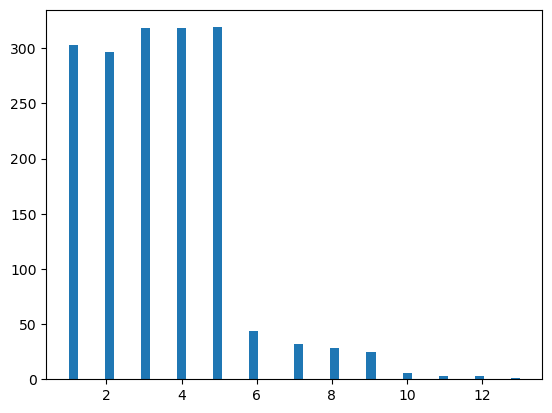

In [77]:
plt.hist(agg_df01["total_quantity"], bins=50)

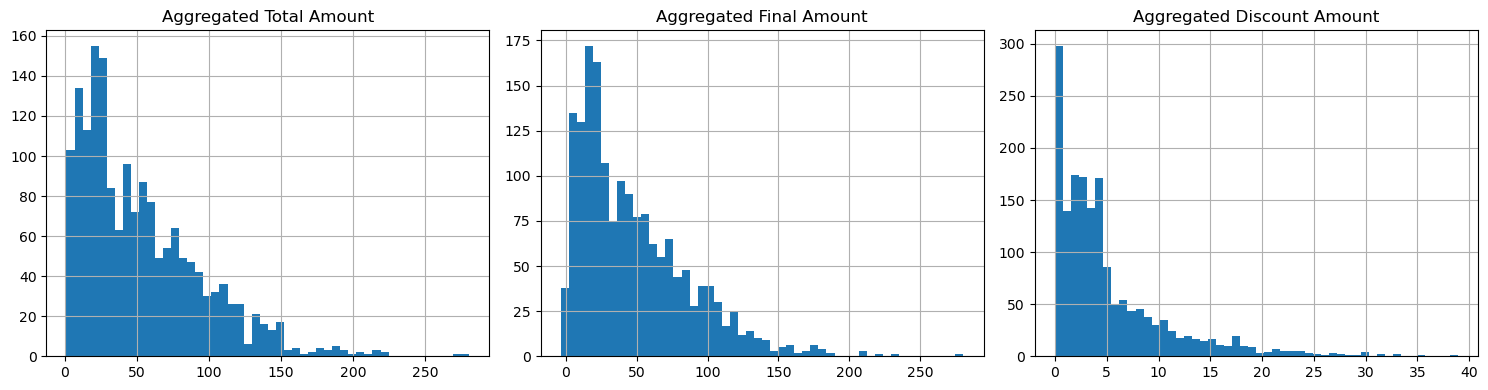

In [78]:
# 分布確認
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

agg_df01["total_amount"].hist(bins=50, ax=axes[0])
axes[0].set_title("Aggregated Total Amount")

agg_df01["final_amount"].hist(bins=50, ax=axes[1])
axes[1].set_title("Aggregated Final Amount")

agg_df01["total_discount"].hist(bins=50, ax=axes[2])
axes[2].set_title("Aggregated Discount Amount")

plt.tight_layout()
plt.show()

- 日×店舗でのtotal_quantityは6~12の範囲でデータの量が増えているが依然として1~5の範囲に大部分が収まっており粒度を下げた状態でも情報量が少ないことが分かる
- 日×店舗でのAggregated Total Amount、Aggregated Final Amount、Discount Amountについては粒度を下げた分範囲に多少の違いはあるが分布が右に偏っていることは変わらず大きな違いは見られない。

## カテゴリカルデータの処理

### Target Encoding

store_name および aisle はカテゴリ数が多く、
One-Hot Encoding では次元が過剰になるため、
過去データのみを用いたターゲットエンコーディングを採用した。

各取引日の特徴量には当日の final_amount を使用せず、
同一カテゴリにおける過去の平均売上金額を累積的に計算することで
リークを防止している。


In [79]:
agg_df = agg_df.sort_values("transaction_date").reset_index(drop=True)

global_mean = agg_df["final_amount"].mean()

# 店舗名のターゲットエンコーディング
store_stats = (
    agg_df
    .groupby("store_name")["final_amount"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

agg_df["store_te"] = store_stats
agg_df["store_te"] = agg_df["store_te"].fillna(global_mean)

# 商品カテゴリのターゲットエンコーディング
aisle_stats = (
    agg_df
    .groupby("aisle")["final_amount"]
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

agg_df["aisle_te"] = aisle_stats
agg_df["aisle_te"] = agg_df["aisle_te"].fillna(global_mean)


In [86]:
agg_df.head(5)


,transaction_date,store_name,aisle,total_quantity,total_amount,total_discount,final_amount,avg_unit_price,avg_loyalty_points,transaction_count,discount_rate,price_per_item,has_discount,quantity_per_tx,year,month,dayofweek,is_weekend,store_te,aisle_te
0,2023-08-07,City Fresh Store,Beverages,1.0,28.26,0.00,28.26,28.26,416.0,1,0.000000,28.26,0,1.0,2023,8,0,0,41.805969,40.851356
1,2023-08-07,ValuePlus Market,Meat & Seafood,1.0,15.33,3.07,12.26,15.33,426.0,1,0.200261,12.26,1,1.0,2023,8,0,0,42.876043,39.382035
2,2023-08-08,Corner Grocery,Bakery,5.0,117.30,0.00,117.30,23.46,471.0,1,0.000000,23.46,0,5.0,2023,8,1,0,42.011588,41.805969
3,2023-08-08,FamilyFood Express,Meat & Seafood,1.0,25.05,1.86,23.19,25.05,283.0,1,0.074251,23.19,1,1.0,2023,8,1,0,42.991019,12.260000
4,2023-08-08,FreshMart Downtown,Dairy,5.0,60.25,12.05,48.20,12.05,204.0,1,0.200000,9.64,1,5.0,2023,8,1,0,36.073458,42.438587


- store_name および aisle はターゲットエンコーディングにより
数値特徴量へ変換済みであるため、
学習時には元のカテゴリ列を使用しない設計とした。


In [81]:
# 学習用データを作る
feature_cols = [
    "total_quantity",
    "total_amount",
    "total_discount",
    "avg_unit_price",
    "avg_loyalty_points",
    "transaction_count",
    "discount_rate",
    "price_per_item",
    "has_discount",
    "quantity_per_tx",
    "year",
    "month",
    "dayofweek",
    "is_weekend",
    "store_te",
    "aisle_te",
]

model_df = agg_df[feature_cols + ["final_amount"]].copy()


- 店舗ごとの週末効果を表現する特徴量として
store_te × is_weekend を検討したが、
本特徴量は平日との比較情報を明示的に含まないため、
週末効果を適切に表現できないと判断した。
そのため、store_te と is_weekend は独立した特徴量として扱う。

- aisle_te × monthも検討したが月は周期的な変数であり、数値として扱いカテゴリ平均との差分を掛け合わせると単調増加バイアスを生むと判断したため、本特徴量は採用しなかった。

In [ ]:

from pathlib import Path

output_dir = Path("../data/processed")
agg_df.to_csv(
    output_dir / "features_v1.csv",
    index=False
)

model_df.to_csv(
    output_dir / "model_df.csv",
    index=False
)